# Modelling the Coronavirus outbreak in the Netherlands

## Background and model dynamics

The main purpose of the notebook is to:

- Understand better the dynamics of the Coronavirus outbreak -> what are key parameters?
- Understand the current development -> is the curve 'flattening'?
- Think about possible mitigation strategies

I will use the SEIR model to model the epidemic. This broadly used model is explained here: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

In short, it assumes that in a population there are four compartments of people during an infection:

S - Susceptible - not yet sick, but can become sick \
E - Exposed - people who have the virus, and are in the incubation period. They are not infectious or sick yet \
I - Infected - people who are sick and infectious \
R - Removed - people who either recovered or died from the virus




If we simplify by neglecting for the moment birth rates & deaths (other than from Corona), the model is governed by the following equations;


\begin{aligned}{\frac{dS}{dt}}&= -\beta {\frac {I}{N}}S,\\[8pt]{\frac {dE}{dt}}&=\beta {\frac {I}{N}}S- a E,\\[8pt]{\frac {dI}{dt}}&=aE-\gamma I,\\[8pt]{\frac {dR}{dt}}&=\gamma I .\end{aligned}

with key parameters;

\begin{aligned}{a^{-1} = T_{incubation}},\\
\\
{\beta^{-1} = T_{contacts}}, \\
\\
\gamma^{-1} = T_{recovery},\\
\\
R_0 = \frac{\beta}{\gamma}.\end{aligned}


where T_contacts is the typical time between contacts, T_recovery the typical time to recovery and T_incubation the average incubation time. \
\
We will model the current epidemic in the Netherlands using this theoretical model.

## Expanding the model

The SEIR model schematically works as depicted below, people flowing from one container to the other, with the dynamics described in the above differential equations.

In [295]:
%%html
<img src = "img/SEIR.png", width = 600, height = 400)>

In [306]:
# First we will import some packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#We create a function to model the above differential equations, where y is a vector of S, E, I and R, N the population size
# a the average incubation period, beta the time between contacts and gamma the recovery time
def deriv(y, t, N, a, beta, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - a * E
    dIdt = a * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

#A function to simulate an integration over time, with S0,E0,I0,R0 the starting conditions of the function, 
#t_n the number of steps (days), and N the population size
def simulation(S0, E0, I0,R0, t_n, N, a, beta, gamma):
    t = np.linspace(0, t_n-1, t_n)
    y0 = S0, E0, I0, R0
    ret = odeint(deriv, y0, t, args=(N, a, beta, gamma))
    S, E, I, R = ret.T
    return S, E, I, R, N, t

# a function to plot the simulation
def plot(S,E,I,R,N,t,scale):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S/scale, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, E/scale, 'y', alpha=0.5, lw=2, label='Exposed')
    ax.plot(t, I/scale, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/scale, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,N/1000+50)
    ax.set_ylim(0,20000)
    #ax.set_xlim(0,30)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

In [307]:
# Dutch situation
N_NL = 17000000 #pop size
E0, I0, R0 = 500, 100, 0 # Initial number of exposed, infected and recovered individuals, I0 and R0.
S0 = N_NL - E0 - I0 - R0 # Everyone else, S0, is susceptible to infection initially.

R_zero = 2

# Estimates for the incubation time, a, the contact rate, beta, and mean recovery time, gamma, (in 1/days).
a, gamma, beta = 1./2, 1./14, gamma * R_zero
t = 200 # the number of time steps

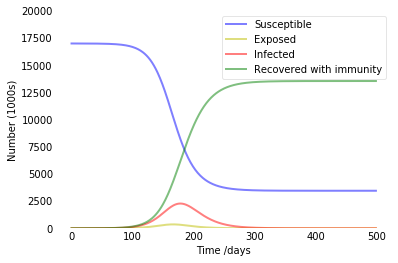

In [308]:
# making a first simulation
S,E,I,R,N,t = simulation(S0,E0,I0,R0,500,N_NL,a,beta,gamma)
plot(S,E,I,R,N,t,1000)

In [169]:
#Measured infections in the Netherlands
I_measured_NL = np.array([10,20,30,40,80,130,190,270,320,380,500,610,800,960,1140,1410,1710,2051,2460,2994,3631,4204,4749,5560])
H_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,124,142,181,271,350,413,537,700,809,1051,1295])
IC_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,130,175,210,281,354,405,487,550])
D_measured_NL = np.array([0,0,0,0,0,0,0,0,0,0,0,0,10,12,20,24,43,58,76,106,136,179,213,276])
IC_capacity_NL = np.ones(I_measured.size)*2000

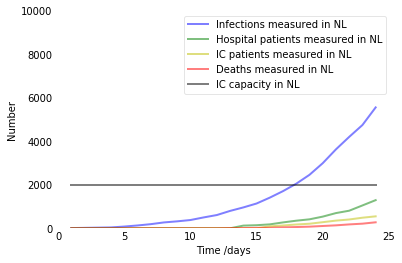

In [214]:
t = np.linspace(1, I_measured_NL.size,I_measured_NL.size)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, I_measured_NL, 'b', alpha=0.5, lw=2, label='Infections measured in NL')
ax.plot(t, H_measured_NL, 'g', alpha=0.5, lw=2, label='Hospital patients measured in NL')
ax.plot(t, IC_measured_NL, 'y', alpha=0.5, lw=2, label='IC patients measured in NL')
ax.plot(t, D_measured_NL, 'r', alpha=0.5, lw=2, label='Deaths measured in NL')
ax.plot(t, IC_capacity_NL, 'black', alpha=0.5, lw=2, label='IC capacity in NL')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,10000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [180]:
#Germany numbers from March 1st 2020 onwards:
I_measured_GER = np.array([130,165,203,262,545,670,800,1040,1224,1565,1966,2745,3675,4599,5813,7272,9367,12327,15320,19848,22364,24873,29056,29056])
H_measured_GER = np.array([])
IC_measured_GER = np.array([])
D_measured_GER = np.array([0,0,0,0,0,0,0,0,2,2,3,6,8,9,13,17,26,28,44,68,84,94,123,0])
IC_capacity_GER = np.ones(I_measured.size)*2000

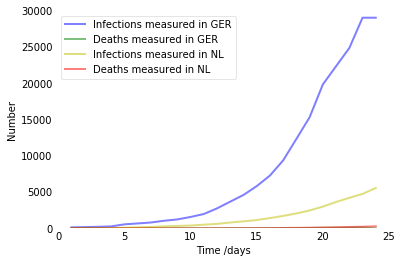

In [181]:
#plotting the real Germany situation
t = np.linspace(1, I_measured_GER.size,I_measured_GER.size)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, I_measured_GER, 'b', alpha=0.5, lw=2, label='Infections measured in GER')
ax.plot(t, D_measured_GER, 'g', alpha=0.5, lw=2, label='Deaths measured in GER')
ax.plot(t, I_measured_NL, 'y', alpha=0.5, lw=2, label='Infections measured in NL')
ax.plot(t, D_measured_NL, 'r', alpha=0.5, lw=2, label='Deaths measured in NL')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,30000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [281]:
# Germany situation
N_Ger = 87790000 #pop size
E0, I0, R0 = 4000, 2000, 0 # Initial number of exposed, infected and recovered individuals, I0 and R0.
S0 = N_Ger - E0 - I0 - R0 # Everyone else, S0, is susceptible to infection initially.

R_zero = 2.4

# Estimates for the incubation time, a, the contact rate, beta, and mean recovery time, gamma, (in 1/days).
a, gamma, beta = 1./2, 1./14, gamma * R_zero
t = 24 # the number of time steps



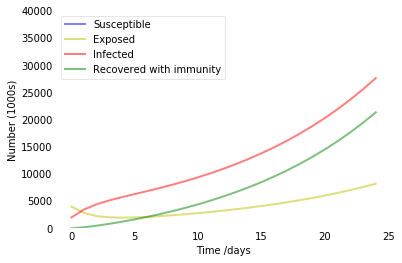

In [282]:
#Germany simulation
S,E,I,R,N,t = simulation(S0, E0, I0, R0, 25, N_Ger, a, beta, gamma)
plot(S,E,I,R,N,t,1)